# setup


In [1]:
import math
import os
import re
import json

import datasets

# from datasets import load_dataset
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from dtreeviz.trees import dtreeviz
from scipy.stats import norm
from scipy.cluster import hierarchy as hc
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall


os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

/home/andrewhinh/Desktop/Projects/finemath/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
num_samples = 100000
save_path = "finemath-4plus-100k"
processed_path = "data/"

# preprocessing

## load full and save subset

In [3]:
# data = load_dataset("HuggingFaceTB/finemath", "finemath-4plus", split="train", cache_dir=None, num_proc=8)
# data

In [4]:
# data = data.shuffle(seed=seed).select(range(num_samples))
# data

In [5]:
# data.save_to_disk(save_path)

## load subset

In [47]:
data = datasets.load_from_disk(save_path)
data


Dataset({
    features: ['url', 'fetch_time', 'content_mime_type', 'warc_filename', 'warc_record_offset', 'warc_record_length', 'text', 'token_count', 'char_count', 'metadata', 'score', 'int_score', 'crawl', 'snapshot_type', 'language', 'language_score'],
    num_rows: 100000
})

In [48]:
df = data.to_pandas()
df.head()


,url,fetch_time,content_mime_type,warc_filename,...,crawl,snapshot_type,language,language_score
0,https://www.gradesaver.com/textbooks/math/calc...,1576415061000000000,text/html,crawl-data/CC-MAIN-2019-51/segments/1575541308...,...,CC-MAIN-2019-51,latest,en,0.745761
1,https://www.physicsforums.com/threads/financia...,1519549007000000000,text/html,crawl-data/CC-MAIN-2018-09/segments/1518891816...,...,CC-MAIN-2018-09,longest,en,0.968464
2,https://quizanswered.com/module-8-ac-amplifier...,1686384188000000000,text/html,crawl-data/CC-MAIN-2023-23/segments/1685224657...,...,CC-MAIN-2023-23,latest,en,0.855330
3,https://workforce.libretexts.org/Bookshelves/E...,1582270100000000000,text/html,crawl-data/CC-MAIN-2020-10/segments/1581875145...,...,CC-MAIN-2020-10,latest,en,0.920674
4,https://www.physicsforums.com/threads/inequali...,1505907042000000000,text/html,crawl-data/CC-MAIN-2017-39/segments/1505818687...,...,CC-MAIN-2017-39,longest,en,0.877909


## feature engineering

```python
Schema:
{
    'url': string,               # Source page URL
    'fetch_time': int64,         # Crawler timestamp
    'content_mime_type': string, # MIME type
    'warc_filename': string,     # Common Crawl WARC source file
    'warc_record_offset': int32, # WARC record offset, in bytes
    'warc_record_length': int32, # WARC record size, in bytes
    'text': string,             # Page content
    'token_count': int32,       # Number of Llama tokens
    'char_count': int32,        # Character count
    'metadata': string,         # Additional OpenWebMath metadata
    'score': float64,           # Raw quality score
    'int_score': int64,         # Integer quality score
    'crawl': string,            # Common Crawl crawl identifier
    'snapshot_type': string,    # Whether the page is the latest or the largest for this URL
    'language': string,         # Document language
    'language_score': float64   # LangID probability
}
```

### dependent variable

Convert score to N(0,1) distribution and remove int_score column.

In [49]:
df["score"].describe()

count    100000.000000
mean          3.976711
std           0.352080
min           3.500000
25%           3.687500
50%           3.906250
75%           4.218750
max           5.125000
Name: score, dtype: float64

In [50]:
min_score, max_score = df["score"].min(), df["score"].max()
print(f"Min score: {min_score}, Max score: {max_score}")


Min score: 3.5, Max score: 5.125


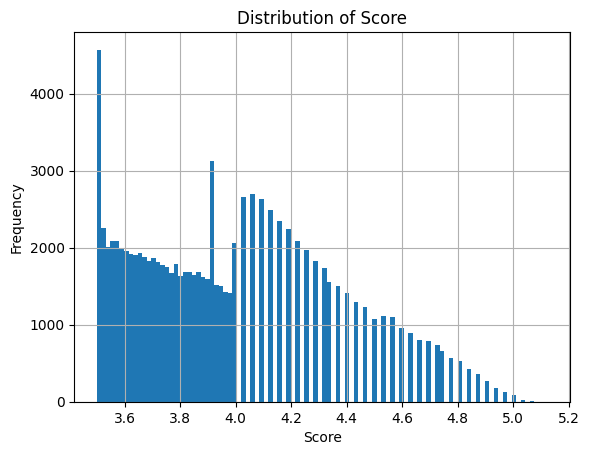

In [51]:
df["score"].hist(bins=100)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Score")
plt.show()


In [52]:
class RankINT:
    """Forward = exact N(0,1); inverse = quantile interpolation."""

    def fit(self, y: pd.Series | np.ndarray):
        y = np.asarray(y, float)
        self.y_sorted = np.sort(y)
        n = len(y)
        self.z_grid = norm.ppf(
            (np.arange(1, n + 1) - 0.5) / n
        )  # convert to percentile -> z-score
        self._inv = interp1d(
            self.z_grid,
            self.y_sorted,
            bounds_error=False,
            fill_value=(self.y_sorted[0], self.y_sorted[-1]),
        )  # 1-D monotone interpolation for inverse transform
        return self

    def transform(self, y: pd.Series | np.ndarray):
        """Forward INT (needs the full vector because of ranks)."""
        y = pd.Series(y)
        r = y.rank(method="first").to_numpy()  # 1 … n
        n = len(y)
        return norm.ppf((r - 0.5) / n)

    def inverse_transform(self, z_pred: float | np.ndarray):
        """Map a single (or array of) N(0,1) value(s) back to score space."""
        return self._inv(z_pred)


In [53]:
int_tf = RankINT().fit(df["score"])  # store mapping
df["score"] = int_tf.transform(df["score"])
df["score"].describe()

count    1.000000e+05
mean    -1.421085e-17
std      9.999983e-01
min     -4.417173e+00
25%     -6.744819e-01
50%      6.957359e-17
75%      6.744819e-01
max      4.417173e+00
Name: score, dtype: float64

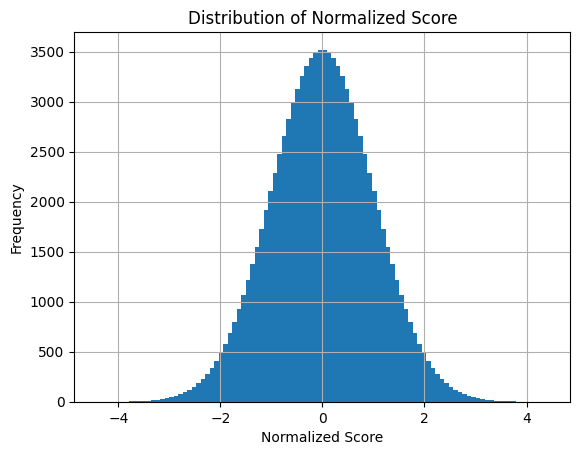

In [13]:
df["score"].hist(bins=100)
plt.xlabel("Normalized Score")
plt.ylabel("Frequency")
plt.title("Distribution of Normalized Score")
plt.show()


In [14]:
df.drop(columns=["int_score"], inplace=True)
df.head()

,url,fetch_time,content_mime_type,warc_filename,...,crawl,snapshot_type,language,language_score
0,https://www.gradesaver.com/textbooks/math/calc...,1576415061000000000,text/html,crawl-data/CC-MAIN-2019-51/segments/1575541308...,...,CC-MAIN-2019-51,latest,en,0.745761
1,https://www.physicsforums.com/threads/financia...,1519549007000000000,text/html,crawl-data/CC-MAIN-2018-09/segments/1518891816...,...,CC-MAIN-2018-09,longest,en,0.968464
2,https://quizanswered.com/module-8-ac-amplifier...,1686384188000000000,text/html,crawl-data/CC-MAIN-2023-23/segments/1685224657...,...,CC-MAIN-2023-23,latest,en,0.855330
3,https://workforce.libretexts.org/Bookshelves/E...,1582270100000000000,text/html,crawl-data/CC-MAIN-2020-10/segments/1581875145...,...,CC-MAIN-2020-10,latest,en,0.920674
4,https://www.physicsforums.com/threads/inequali...,1505907042000000000,text/html,crawl-data/CC-MAIN-2017-39/segments/1505818687...,...,CC-MAIN-2017-39,longest,en,0.877909


### dates

Use date column `fetch_time` to create features.


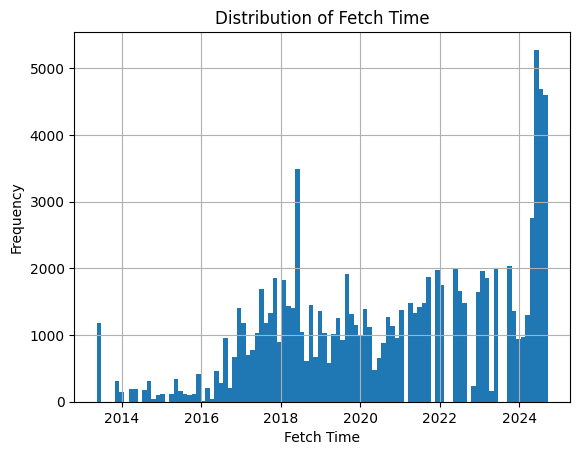

In [15]:
def make_date(df, date_field):  # make sure `df[date_field]` is of the right date type
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field])


make_date(df, "fetch_time")
df["fetch_time"].hist(bins=100)
plt.xlabel("Fetch Time")
plt.ylabel("Frequency")
plt.title("Distribution of Fetch Time")
plt.show()

In [16]:
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    make_date(df, field_name)
    field = df[field_name]
    prefix = prefix if prefix else re.sub("[Dd]ate$", "", field_name)
    attr = [
        "Year",
        "Month",
        "Week",
        "Day",
        "Dayofweek",
        "Dayofyear",
        "Is_month_end",
        "Is_month_start",
        "Is_quarter_end",
        "Is_quarter_start",
        "Is_year_end",
        "Is_year_start",
    ]
    if time:
        attr = attr + ["Hour", "Minute", "Second"]
    # Pandas removed `dt.week` in v1.1.10
    week = (
        field.dt.isocalendar().week.astype(field.dt.day.dtype)
        if hasattr(field.dt, "isocalendar")
        else field.dt.week
    )
    for n in attr:
        df[prefix + n] = getattr(field.dt, n.lower()) if n != "Week" else week
    mask = ~field.isna()
    df[prefix + "Elapsed"] = np.where(
        mask, field.values.astype(np.int64) // 10**9, np.nan
    )
    if drop:
        df.drop(field_name, axis=1, inplace=True)


add_datepart(df, "fetch_time")
" ".join(o for o in df.columns if o.startswith("fetch_time"))

'fetch_timeYear fetch_timeMonth fetch_timeWeek fetch_timeDay fetch_timeDayofweek fetch_timeDayofyear fetch_timeIs_month_end fetch_timeIs_month_start fetch_timeIs_quarter_end fetch_timeIs_quarter_start fetch_timeIs_year_end fetch_timeIs_year_start fetch_timeElapsed'

### load metadata

In [17]:
df["metadata"] = df["metadata"].apply(json.loads)
df.loc[0, "metadata"]

{'found_math': True,
 'script_math_tex': 0,
 'script_math_asciimath': 0,
 'math_annotations': 0,
 'math_alttext': 0,
 'mathml': 0,
 'mathjax_tag': 0,
 'mathjax_inline_tex': 1,
 'mathjax_display_tex': 0,
 'mathjax_asciimath': 0,
 'img_math': 0,
 'codecogs_latex': 0,
 'wp_latex': 0,
 'mimetex.cgi': 0,
 '/images/math/codecogs': 0,
 'mathtex.cgi': 0,
 'katex': 0,
 'math-container': 0,
 'wp-katex-eq': 0,
 'align': 0,
 'equation': 0,
 'x-ck12': 0,
 'texerror': 0}

In [18]:
def check_metadata_fields(df):
    first_metadata_keys = set(df.loc[0, "metadata"].keys())
    all_same_fields = True

    for i, metadata in enumerate(df["metadata"]):
        if set(metadata.keys()) != first_metadata_keys:
            all_same_fields = False
            print(f"Row {i} has different metadata fields than the first row")
            print(f"First row fields: {first_metadata_keys}")
            print(f"Row {i} fields: {set(metadata.keys())}")
            break

    assert all_same_fields, "Not all rows have the same metadata fields"
    print("All rows in metadata column have the same fields")


check_metadata_fields(df)


All rows in metadata column have the same fields


In [19]:
def extract_metadata_fields(df):
    metadata_fields = list(df.loc[0, "metadata"].keys())
    print(f"Extracting {len(metadata_fields)} metadata fields to separate columns")

    for field in metadata_fields:
        df[f"metadata_{field}"] = df["metadata"].apply(lambda x: x.get(field, None))

    df.drop("metadata", axis=1, inplace=True)
    print(
        f"Created new columns: {', '.join(['metadata_' + field for field in metadata_fields])}"
    )
    print(f"Dropped original metadata column")


extract_metadata_fields(df)


Extracting 23 metadata fields to separate columns
Created new columns: metadata_found_math, metadata_script_math_tex, metadata_script_math_asciimath, metadata_math_annotations, metadata_math_alttext, metadata_mathml, metadata_mathjax_tag, metadata_mathjax_inline_tex, metadata_mathjax_display_tex, metadata_mathjax_asciimath, metadata_img_math, metadata_codecogs_latex, metadata_wp_latex, metadata_mimetex.cgi, metadata_/images/math/codecogs, metadata_mathtex.cgi, metadata_katex, metadata_math-container, metadata_wp-katex-eq, metadata_align, metadata_equation, metadata_x-ck12, metadata_texerror
Dropped original metadata column


### categorical variables

Identify and convert to numeric.


In [20]:
def cont_cat_split(df, max_card=20, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label == "score":
            continue
        if (
            pd.api.types.is_integer_dtype(df[label].dtype)
            and df[label].unique().shape[0] > max_card
        ) or pd.api.types.is_float_dtype(df[label].dtype):
            cont_names.append(label)
        else:
            cat_names.append(label)
    return cont_names, cat_names


cont, cat = cont_cat_split(df, 1, dep_var="score")
print(f"{len(cont)} continuous variables, {len(cat)} categorical variables")

33 continuous variables, 15 categorical variables


#### text columns

Determine via high cardinality and convert to numeric via TF-IDF.


In [21]:
low_card_cat = [col for col in cat if df[col].nunique() < 10000]
text_cols = list(set(cat) - set(low_card_cat))
cat = low_card_cat
cat, text_cols


(['content_mime_type',
  'crawl',
  'snapshot_type',
  'language',
  'fetch_timeIs_month_end',
  'fetch_timeIs_month_start',
  'fetch_timeIs_quarter_end',
  'fetch_timeIs_quarter_start',
  'fetch_timeIs_year_end',
  'fetch_timeIs_year_start',
  'metadata_found_math',
  'metadata_katex'],
 ['url', 'warc_filename', 'text'])

In [22]:
def process_text_columns(df, text_columns, max_features=100):
    tfidf_matrix = None
    tfidf = TfidfVectorizer(max_features=max_features)

    for col in text_columns:
        text = df[col]
        col_tfidf = tfidf.fit_transform(text)
        if tfidf_matrix is None:
            tfidf_matrix = col_tfidf
        else:
            tfidf_matrix = hstack([tfidf_matrix, col_tfidf])

    feature_names = []
    for col in text_columns:
        for i in range(len(tfidf.get_feature_names_out())):
            feature_names.append(f"{col}_tfidf_{i}")

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    df = pd.concat([df, tfidf_df], axis=1)
    df.drop(columns=text_cols, inplace=True)
    return df


df = process_text_columns(df, text_cols)
tfidf_feature_names = [col for col in df.columns if "_tfidf_" in col]
cont.extend(tfidf_feature_names)
print(
    f"Added {len(tfidf_feature_names)} TF-IDF features from {len(text_cols)} text columns"
)

Added 300 TF-IDF features from 3 text columns


#### convert to codes


In [23]:
for col in cat:
    df[col] = df[col].astype("category").cat.codes

df.loc[:5, cat[0]]

0    1
1    1
2    1
3    1
4    1
5    1
Name: content_mime_type, dtype: int8

### check for missing values

In [24]:
has_missing = df.isnull().any().any()
print(f"Dataset has missing values: {has_missing}")
if has_missing:
    print("\nColumns with missing values:")
    print(df.columns[df.isnull().any()].tolist())


Dataset has missing values: False


### train:valid:test split

.8:.1:.1

In [25]:
" ".join(o for o in df.columns if o.startswith("fetch_time"))

'fetch_timeYear fetch_timeMonth fetch_timeWeek fetch_timeDay fetch_timeDayofweek fetch_timeDayofyear fetch_timeIs_month_end fetch_timeIs_month_start fetch_timeIs_quarter_end fetch_timeIs_quarter_start fetch_timeIs_year_end fetch_timeIs_year_start fetch_timeElapsed'

In [26]:
df = df.sort_values("fetch_timeElapsed")

total_rows = len(df)
train_end_idx = int(total_rows * 0.8)
valid_end_idx = train_end_idx + int(total_rows * 0.1)

train_df = df.iloc[:train_end_idx].copy()
valid_df = df.iloc[train_end_idx:valid_end_idx].copy()
test_df = df.iloc[valid_end_idx:].copy()

print(f"Split sizes: Train={len(train_df)}, Valid={len(valid_df)}, Test={len(test_df)}")


Split sizes: Train=80000, Valid=10000, Test=10000


In [27]:
assert train_df[
    "fetch_timeElapsed"
].is_monotonic_increasing, "Train data is not in chronological order"
assert valid_df[
    "fetch_timeElapsed"
].is_monotonic_increasing, "Validation data is not in chronological order"
assert test_df[
    "fetch_timeElapsed"
].is_monotonic_increasing, "Test data is not in chronological order"

assert (
    train_df["fetch_timeElapsed"].max() <= valid_df["fetch_timeElapsed"].min()
), "Train and validation time periods overlap"
assert (
    valid_df["fetch_timeElapsed"].max() <= test_df["fetch_timeElapsed"].min()
), "Validation and test time periods overlap"

print("Chronological order verified for all datasets")


Chronological order verified for all datasets


### save to disk


In [28]:
if not os.path.exists(processed_path):
    os.mkdir(processed_path)
train_df.to_csv(processed_path + "train.csv.gz", compression="gzip", index=False)
valid_df.to_csv(processed_path + "valid_manual.csv.gz", compression="gzip", index=False)
test_df.to_csv(
    path_or_buf=processed_path + "test_manual.csv.gz", compression="gzip", index=False
)


# column pruning and model fitting


In [3]:
train_df = pd.read_csv(
    processed_path + "train.csv.gz", compression="gzip", low_memory=False
)
valid_df = pd.read_csv(
    processed_path + "valid.csv.gz", compression="gzip", low_memory=False
)
test_df = pd.read_csv(
    processed_path + "test.csv.gz", compression="gzip", low_memory=False
)

train_df.columns


Index(['content_mime_type', 'warc_record_offset', 'warc_record_length',
       'token_count', 'char_count', 'score', 'crawl', 'snapshot_type',
       'language', 'language_score',
       ...
       'text_tfidf_90', 'text_tfidf_91', 'text_tfidf_92', 'text_tfidf_93',
       'text_tfidf_94', 'text_tfidf_95', 'text_tfidf_96', 'text_tfidf_97',
       'text_tfidf_98', 'text_tfidf_99'],
      dtype='object', length=346)

## decision tree


### testing visualization


In [4]:
xs_train = train_df.drop(columns=["score"])
y_train = train_df["score"]

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs_train, y_train)


DecisionTreeRegressor(max_leaf_nodes=4)

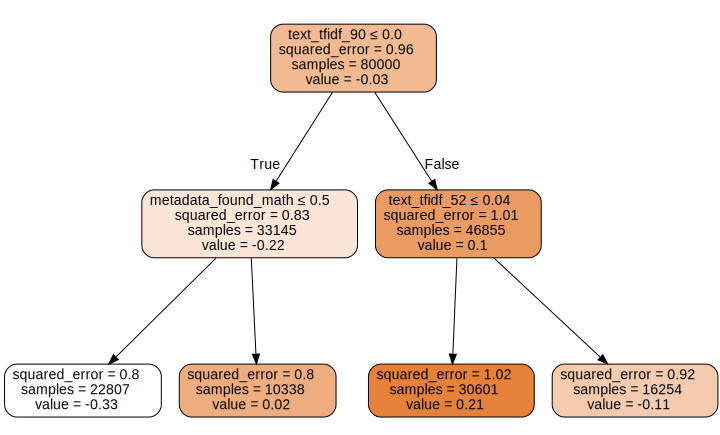

In [5]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s = export_graphviz(
        t,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        rounded=True,
        special_characters=True,
        rotate=False,
        precision=precision,
        **kwargs,
    )
    return graphviz.Source(re.sub("Tree {", f"Tree {{ size={size}; ratio={ratio}", s))


draw_tree(m, xs_train, size=10, leaves_parallel=True, precision=2)


/home/andrewhinh/Desktop/Projects/finemath/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


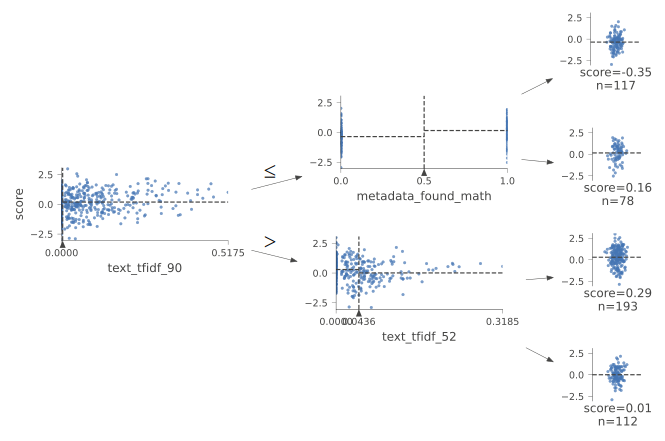

In [6]:
samp_idx = np.random.permutation(len(y_train))[:500]
dtreeviz(
    m,
    xs_train.iloc[samp_idx],
    y_train.iloc[samp_idx],
    xs_train.columns,
    "score",
    fontname="DejaVu Sans",
    scale=1.6,
    label_fontsize=10,
    orientation="LR",
)


### full tree

Check that overfitting occurs without setting min_samples_leaf.


In [7]:
m = DecisionTreeRegressor()
m.fit(xs_train, y_train);


In [10]:
xs_valid = valid_df[xs_train.columns]
y_valid = valid_df["score"]


def r_mse(pred, y):
    return round(math.sqrt(((pred - y) ** 2).mean()), 6)


def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)


m_rmse(m, xs_train, y_train), m_rmse(m, xs_valid, y_valid)


(0.0, 1.27691)

In [11]:
m.get_n_leaves(), len(xs_train)


(np.int64(80000), 80000)

### pruned tree


In [12]:
m = DecisionTreeRegressor(min_samples_leaf=100)
m.fit(xs_train, y_train)
m_rmse(m, xs_train, y_train), m_rmse(m, xs_valid, y_valid)


(0.84858, 0.965637)

In [13]:
m.get_n_leaves()


np.int64(610)

## random forest


In [14]:
def rf(
    xs,
    y,
    n_estimators=40,  # for sake of speed
    max_samples=1.0,
    max_features=0.5,
    min_samples_leaf=5,
    **kwargs,
):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True,
        **kwargs,
    ).fit(xs, y)


m = rf(xs_train, y_train)
m_rmse(m, xs_train, y_train), m_rmse(m, xs_valid, y_valid)


(0.472042, 0.880177)

### check impact of n_estimators


In [15]:
preds = np.stack([t.predict(xs_valid.values) for t in m.estimators_])
r_mse(preds.mean(0), y_valid)


0.880177

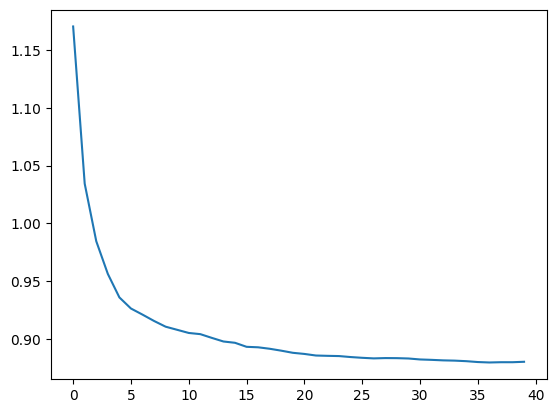

In [16]:
plt.plot([r_mse(preds[: i + 1].mean(0), y_valid) for i in range(40)])
plt.show()


### out-of-bag error

I.e., measure of error on training data by only including in each row's prediction the trees that didn't use that row in training.


In [17]:
r_mse(m.oob_prediction_, y_train)


0.850057

### tree variance for prediction confidence

Trying to answer: How confident are we in our predictions using a particular row of data?


In [18]:
preds = np.stack([t.predict(xs_valid.values) for t in m.estimators_])
preds.shape  # (n_estimators, n_samples)

(40, 10000)

In [19]:
preds_std = preds.std(0)
preds_std[:5]


array([0.63496019, 0.77964834, 0.64647294, 0.68399854, 0.88119266])

### feature importance

Algorithm:

1. For each tree, recursively explore each branch.
2. At each branch, determine what feature was used for that split, and how much the model improves as a result of that split.
3. Add the improvement (weighted by the number of rows in that group) to the importance score for that feature.
4. Sum the importance scores across all branches of all trees, and finally normalize the scores such that they add to 1.

Trying to answer:

- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [20]:
def rf_feat_importance(m, df):
    return pd.DataFrame(
        {"cols": df.columns, "imp": m.feature_importances_}
    ).sort_values("imp", ascending=False)


fi = rf_feat_importance(m, xs_train)
fi[:10]

,cols,imp
335,text_tfidf_90,0.044205
3,token_count,0.025617
284,text_tfidf_39,0.023269
272,text_tfidf_27,0.022231
274,text_tfidf_29,0.018636
271,text_tfidf_26,0.018375
275,text_tfidf_30,0.017549
263,text_tfidf_18,0.017261
297,text_tfidf_52,0.017141
4,char_count,0.014927


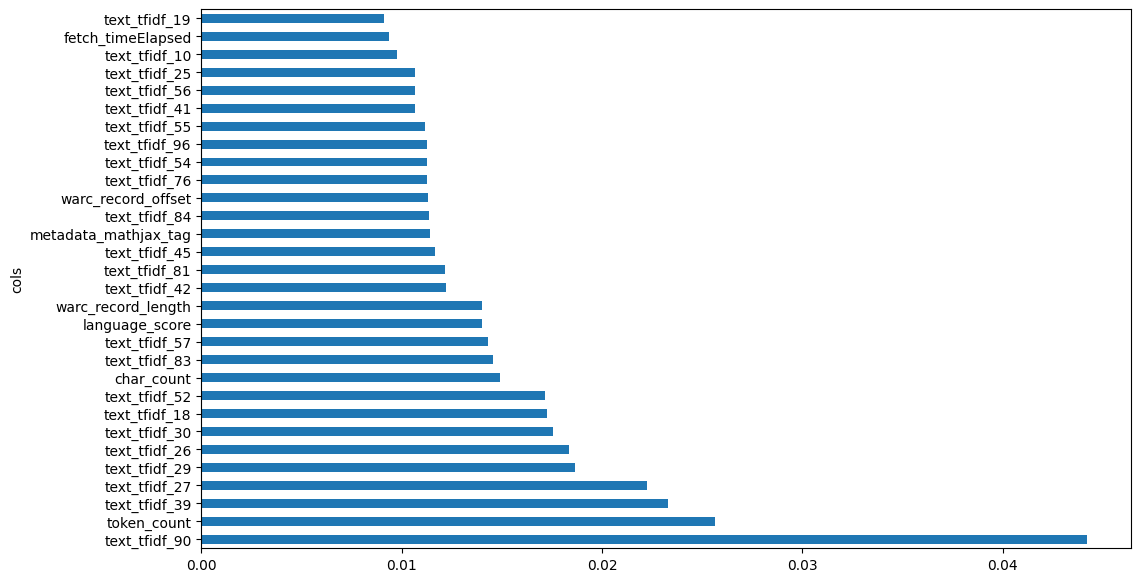

In [21]:
def plot_fi(fi):
    return fi.plot("cols", "imp", "barh", figsize=(12, 7), legend=False)


plot_fi(fi[:30]);

#### remove low importance features


In [22]:
to_keep = fi[fi.imp > 0.01].cols
len(to_keep)


27

In [23]:
xs_imp = xs_train[to_keep]
valid_xs_imp = xs_valid[to_keep]
m = rf(xs_imp, y_train)
m_rmse(m, xs_imp, y_train), m_rmse(m, valid_xs_imp, y_valid)


(0.535545, 0.9045)

In [24]:
len(xs_train.columns), len(xs_imp.columns)


(345, 27)

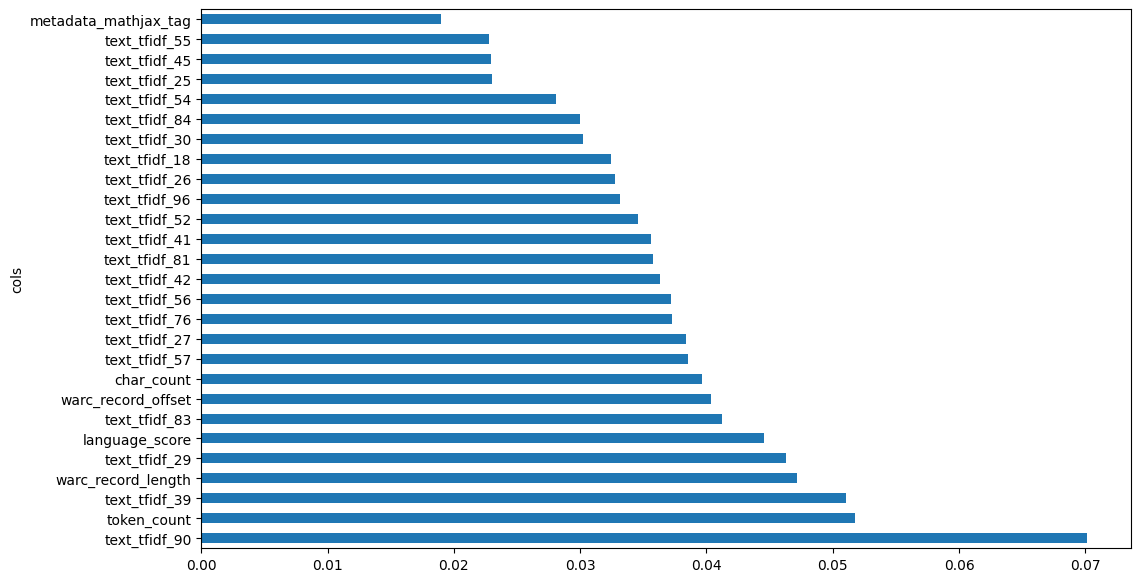

In [25]:
plot_fi(rf_feat_importance(m, xs_imp));


#### remove redundant features

Determine pairs of features that are highly correlated, and remove the least important one from each pair. Similarity is calculated via rank correlation where all values are replaced with rank (1, 2, 3, ...), then the correlation is calculated.


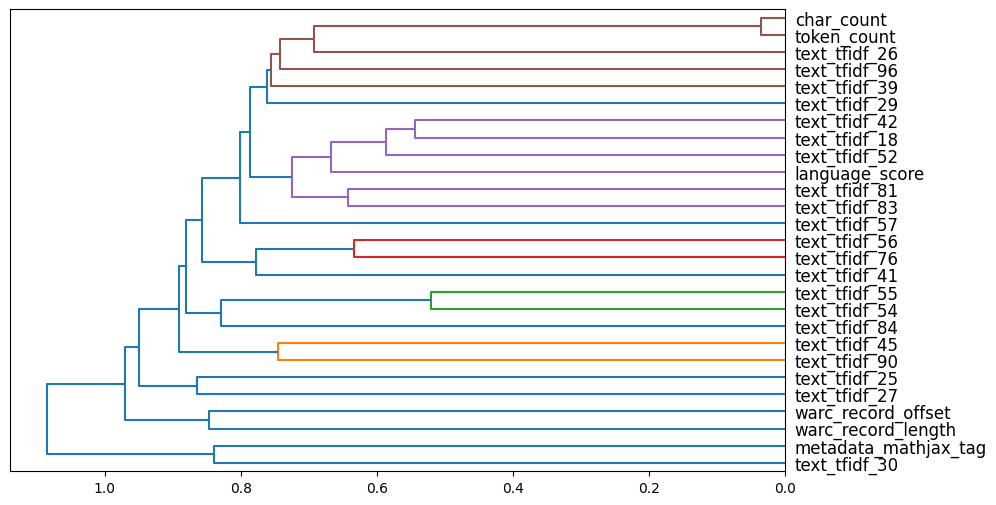

In [26]:
def cluster_columns(df, figsize=(10, 6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1 - corr)
    z = hc.linkage(corr_condensed, method="average")
    plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation="left", leaf_font_size=font_size)
    plt.show()


cluster_columns(xs_imp)


In [27]:
def get_oob(df):
    m = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=15,
        max_samples=50000,
        max_features=0.5,
        n_jobs=-1,
        oob_score=True,  # 1.0 for perfect fit, 0.0 for random fit
    )
    m.fit(df, y_train)
    return m.oob_score_


get_oob(xs_imp)

0.2280924744979238

Try removing potentially redundant features (merged early, i.e., closer to the right)


In [28]:
{
    c: get_oob(xs_imp.drop(c, axis=1))
    for c in (
        "char_count",
        "token_count",
        "text_tfidf_55",
        "text_tfidf_54",
        "text_tfidf_42",
        "text_tfidf_18",
    )
}


{'char_count': 0.22612200770415158,
 'token_count': 0.2205360141966325,
 'text_tfidf_55': 0.22492510537905008,
 'text_tfidf_54': 0.22569677197859672,
 'text_tfidf_42': 0.2267278597486383,
 'text_tfidf_18': 0.22357245699695794}

None give significant improvement, so we keep all features.

#### partial dependence

Check relationship between accommodates + bedrooms (two most important features) and score

Trying to answer: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?


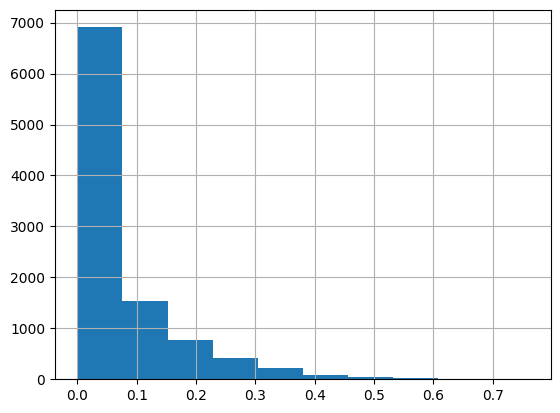

In [29]:
ax = valid_xs_imp["text_tfidf_90"].hist()

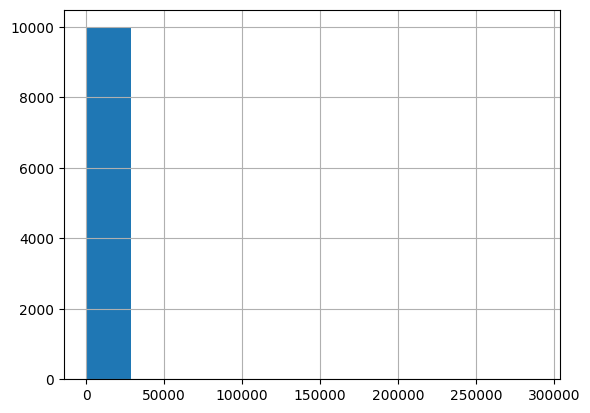

In [30]:
ax = valid_xs_imp["token_count"].hist()


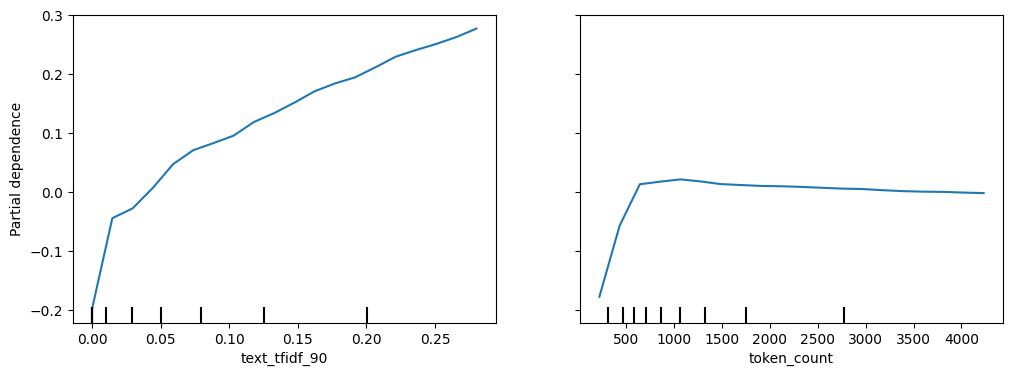

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    m, valid_xs_imp, ["text_tfidf_90", "token_count"], grid_resolution=20, ax=ax
);


From first graph, text_tfidf_90 seems to have near linear relationship with normalized score. From the second graph, token_count seems to also have a linear relationship with normalized score until 600 tokens, after which it seems to have no relationship with normalized score. This is probably indicative of some outlier(s).


#### tree interpreter

Algorithm:

1. For the row in question, put it through the first decision tree to see what split is used at each point throughout the tree.
2. For each split, see what the increase or decrease in the addition is, compared to the parent node of the tree.
3. Do this for every tree, and add up the total change in importance by split variable.

Trying to answer: For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?


In [32]:
row = valid_xs_imp.iloc[:5]
prediction, bias, contributions = treeinterpreter.predict(
    m, row.values
)  # contributions + bias = prediction
prediction[0], bias[0], contributions[0].sum()

(array([-0.23119433]),
 np.float64(-0.03037354370670606),
 np.float64(-0.20082078560590674))

/home/andrewhinh/Desktop/Projects/finemath/.venv/lib/python3.12/site-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/home/andrewhinh/Desktop/Projects/finemath/.venv/lib/python3.12/site-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


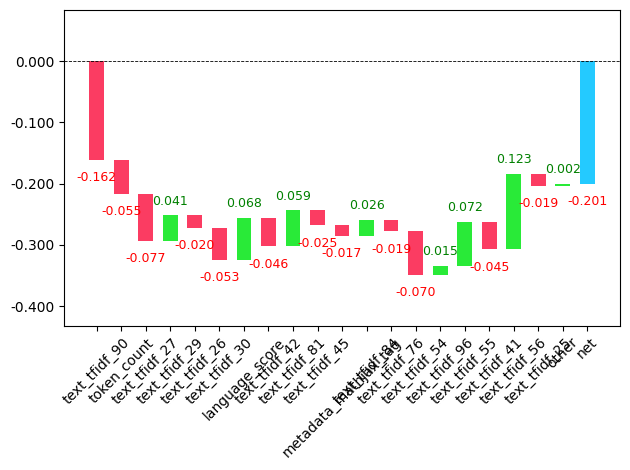

In [33]:
waterfall(
    valid_xs_imp.columns,
    contributions[0],
    threshold=0.08,
    rotation_value=45,
    formatting="{:,.3f}",
);


### extrapolation problem

Check if training data is representative of test data by building random forest on combined training and validation data with dependent variable indicating whether a listing is in the training or validation set.


In [34]:
df_dom = pd.concat([xs_imp, valid_xs_imp])
is_valid = np.array([0] * len(xs_imp) + [1] * len(valid_xs_imp))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]


,cols,imp
19,warc_record_offset,0.148318
13,warc_record_length,0.129386
9,char_count,0.047106
12,language_score,0.047082
20,text_tfidf_76,0.045310
1,token_count,0.042430


Checking if removing these features would improve model performance.


In [35]:
to_drop = [
    "warc_record_offset",
    "warc_record_length",
]

for c in to_drop:
    temp_train = xs_imp.drop(c, axis=1)
    temp_valid = valid_xs_imp.drop(c, axis=1)
    m = rf(temp_train, y_train)
    print(
        c,
        m_rmse(m, temp_train, y_train),
        m_rmse(m, temp_valid, y_valid),
    )

warc_record_offset 0.538524 0.905667
warc_record_length 0.539912 0.907299


It doesn't, so we don't remove them.

## histogram gradient boosting

Inspired by LightGBM, which in turn was inspired by XGBoost.


In [40]:
def hg(
    xs,
    y,
    learning_rate=0.1,
    max_iter=1000,
    min_samples_leaf=31,
    **kwargs,
):
    return HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=learning_rate,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        **kwargs,
    ).fit(xs, y)


m = hg(xs_imp, y_train)
m_rmse(m, xs_imp, y_train), m_rmse(m, valid_xs_imp, y_valid)


(0.765421, 0.89106)

## get test set predictions


In [61]:
xs_test = test_df[xs_imp.columns].copy()
y_test = test_df["score"]
m = hg(xs_imp, y_train)


In [62]:
pred_score = m.predict(xs_test)

errors = y_test - pred_score
abs_errors = errors.abs()
abs_min_error = abs_errors.min()
abs_max_error = abs_errors.max()
mean_abs_error = abs_errors.mean()
median_abs_error = abs_errors.median()
abs_std_error = abs_errors.std()

print(f"RMSE: {m_rmse(m, xs_test, y_test):.6f}")
print(f"Absolute Min Error: {abs_min_error:.6f}")
print(f"Absolute Max Error: {abs_max_error:.6f}")
print(f"Mean Absolute Error: {mean_abs_error:.6f}")
print(f"Median Absolute Error: {median_abs_error:.6f}")
print(f"Standard Deviation of Absolute Error: {abs_std_error:.6f}")

RMSE: 0.917525
Absolute Min Error: 0.000247
Absolute Max Error: 4.257972
Mean Absolute Error: 0.730160
Median Absolute Error: 0.616314
Standard Deviation of Absolute Error: 0.555652


In [66]:
score_recover = int_tf.inverse_transform(y_test)
pred_score_recover = int_tf.inverse_transform(pred_score)

errors = score_recover - pred_score_recover
abs_errors = np.abs(errors)
abs_min_error = np.min(abs_errors)
abs_max_error = np.max(abs_errors)
mean_abs_error = np.mean(abs_errors)
median_abs_error = np.median(abs_errors)
abs_std_error = np.std(abs_errors)

print(f"RMSE: {m_rmse(m, xs_test, y_test):.6f}")
print(f"Absolute Min Error: {abs_min_error:.6f}")
print(f"Absolute Max Error: {abs_max_error:.6f}")
print(f"Mean Absolute Error: {mean_abs_error:.6f}")
print(f"Median Absolute Error: {median_abs_error:.6f}")
print(f"Standard Deviation of Absolute Error: {abs_std_error:.6f}")

RMSE: 0.917525
Absolute Min Error: 0.000000
Absolute Max Error: 1.281250
Mean Absolute Error: 0.263648
Median Absolute Error: 0.218750
Standard Deviation of Absolute Error: 0.202908


In [78]:
sample = xs_test.iloc[0:1]
pred = m.predict(sample)[0]
actual = y_test.iloc[0]
print(f"Columns: {sample.columns}")
print(f"Predicted score: {pred:.6f}")
print(f"Actual score: {actual:.6f}")
print(f"Difference: {pred - actual:.6f}")
print(f"Predicted score recovered: {int_tf.inverse_transform(pred):.6f}")
print(f"Actual score recovered: {int_tf.inverse_transform(actual):.6f}")
print(
    f"Difference recovered: {int_tf.inverse_transform(pred) - int_tf.inverse_transform(actual):.6f}"
)

Columns: Index(['text_tfidf_90', 'token_count', 'text_tfidf_39', 'text_tfidf_27',
       'text_tfidf_29', 'text_tfidf_26', 'text_tfidf_30', 'text_tfidf_18',
       'text_tfidf_52', 'char_count', 'text_tfidf_83', 'text_tfidf_57',
       'language_score', 'warc_record_length', 'text_tfidf_42',
       'text_tfidf_81', 'text_tfidf_45', 'metadata_mathjax_tag',
       'text_tfidf_84', 'warc_record_offset', 'text_tfidf_76', 'text_tfidf_54',
       'text_tfidf_96', 'text_tfidf_55', 'text_tfidf_41', 'text_tfidf_56',
       'text_tfidf_25'],
      dtype='object')
Predicted score: 0.406193
Actual score: 1.058144
Difference: -0.651950
Predicted score recovered: 4.093750
Actual score recovered: 4.406250
Difference recovered: -0.312500
